In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ebwebz8n because the default path (/tmp/cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Lesson 4: modeling a slinky

We will continue solving a spring system (to model a slinky) using the discretization below:

<img src="slinky_held2.png" width=250>

where in the general case, $f_i$ is the applied force and $u_i$ is the corresponding displacement (movement) at mass $m_i$. 

In Lesson 4, you learned that you can obtain the displacement $u_i$ of each mass by solving

$${\bf K}{\bf u} = {\bf f}$$

where ${\bf K}$ is the stiffness matrix, ${\bf u}$ the displacement vector and ${\bf f}$ the force vector.

We will import the functions to construct the stiffness matrix `get_stiffness` and force vector due to gravitational forces `get_force` (you implemented these functions in Lesson 4).

In [2]:
from assemble_functions import get_stiffness
from assemble_functions import get_force

N = 30
Ls  = 10   # (cm)      Length of the slinky
Ks = 700  # (N/cm)     Stiffness
M  = 170  # (grams)    Total mass

m = M/(N+1) # each individual mass
k = Ks*(N)  # each individiual spring stiffness
l = Ls/(N)  # each individual spring length

g = 9.81*10**2 # 386 #(in/s^2)

K = get_stiffness(k*np.ones(N))
f = get_force(m,g,N)

## 1) Solving system of equations for multiple right-hand sides

The function call `u = la.solve(K,f)` solves the system of equations
    
${\bf K}{\bf u} = {\bf f} \leftrightarrow {\bf u} = {\bf K}^{-1}{\bf f} . $

So you could think of the function `la.solve` as performing a matrix inverse every time it is called. However, more efficient methods are available! For example, you can instead compute a LU decomposition, then enact a set of triangular substitutions for solving (solving with triangular matrices is computationally easier):

$ {\bf K} = {\bf PLU} \rightarrow {\bf PLU u} = {\bf f} , $

$ {\bf L y} = {\bf P}^T{\bf f} \rightarrow$ solve for ${\bf y}, $

$ {\bf U u} = {\bf y} \rightarrow$ solve for ${\bf u} . $

#### Use LU decomposition to solve a single linear system.
Write the function `my_LU_solve_1` that uses LU decomposition with permutation and triangular substitutions to solve the linear system of equations, as described above and using the SciPy functions described below.
The function should return the value of the displacement at the free end of the slinky.

Use the LU decomposition function [`scipy.linalg.lu`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu.html) and the function to solve a linear system with a triangular matrix [`scipy.linalg.solve_triangular`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_triangular.html). For the latter, pay attention to the `lower` argument so that forward or backward substitution is correctly specified.

The function should have the following signature:

```python
def my_LU_solve_1(K,f):
    # K: 2d numpy array with the stiffness matrix
    # f: 1d numpy array with the load force
    # compute displacement at the free end
    return # return displacement at the free end
```   

In [3]:
import scipy.linalg as sla

In [4]:
#grade (do not delete this line)
def my_LU_solve_1(K,f):
    # K: 2d numpy array with the stiffness matrix
    # f: 1d numpy array with the load force
    # compute displacement at the free end
    P, L, U = sla.lu(K)
    y = sla.solve_triangular(L, P.transpose() @ f, lower=True)
    u = sla.solve_triangular(U, y, lower=False)
    return u[-1] # return displacement at the free end 

Use your function `my_LU_solve_1` to get the displacement of the free end of the slinky given the above configuration. Note that we will test your function using different input values.

In [5]:
my_LU_solve_1(K,f)

119.12142857142788

You should get the same value using `la.solve`. Try it out!

In [6]:
la.solve(K, f)[-1]

119.12142857142788

However, we still didn't address the issue above regarding the efficiency. But we are getting close! 

You are now given a 2d numpy array `fmany` with multiple right hand-sides. Each force vector `f` is now given as a column of `fmany`. For each force vector, you will have a different displacement at the free end.


In [7]:
p = 20
fmany = np.zeros((N,p))
for i in range(p):
    fmany[:,i] = get_force(m,g,N) + np.random.choice([0,1],N)*g
fmany.shape

(30, 20)

#### Use LU decomposition to solve many related linear systems.
Write the function `my_LU_solve_2` that uses LU decomposition with permutation and triangular substitutions to solve the linear system of equations, this time using multiple right-hand sides.
The function should return a 1d NumPy array containing the value of displacement at the free end of the slinky for each given right-hand side.
 
**Think carefully about your implementation, and how you can make it more efficient. Use the fact that there is a single stiffness matrix K in spite of many force vectors. **

The function should have the following signature:

```python
def my_LU_solve_2(K, fmany):
    # K: 2d numpy array with the stiffness matrix
    # fmany: 2d numpy array with the multiple force vectors as columns
    # compute displacement at the free end for each force vector
    # store these displacements as a 1d numpy array
    return # return array of displacements at the free ends
```

In [8]:
#grade (do not delete this line)
def my_LU_solve_2(K, fmany):
    # K: 2d numpy array with the stiffness matrix
    # fmany: 2d numpy array with the multiple force vectors as columns
    # compute displacement at the free end for each force vector
    res = []
    P, L, U = sla.lu(K)
    for f in fmany.T:
        y = sla.solve_triangular(L, P.transpose() @ f, lower=True)
        u = sla.solve_triangular(U, y, lower=False)
        res.append(u[-1])
    # store these displacements as a 1d numpy array
    print(u.shape)
    return np.asarray(res) ## return array of displacements at the free ends
# print(K.shape)
# print(fmany.shape)


You can check your results using the provided `K` and `fmany` variables (we will be testing your function above using different input variables).

In [9]:
my_LU_solve_2(K,fmany)

(30,)


array([129.63214286, 126.549     , 127.95042857, 133.55614286,
       124.21328571, 130.42628571, 128.74457143, 132.108     ,
       128.41757143, 128.32414286, 125.568     , 126.40885714,
       128.09057143, 130.51971429, 133.46271429, 132.80871429,
       128.511     , 124.11985714, 132.29485714, 133.27585714])

Let us compare your efficient implementation with a naive implementation of `la.solve` . We will use your previous work to define the following functions:

In [10]:
def simulation_LU(m,g,k,N,p):
    # force array
    fmany = np.zeros((N,p))
    for i in range(p):
        fmany[:,i] = get_force(m,g,N) + np.random.choice([0,1],N)*g
    # stiffness matrix
    K = get_stiffness(k*np.ones(N))
    u = my_LU_solve_2(K,fmany)
    
def simulation_naive_solve(m,g,k,N,p):
    # force array
    fmany = np.zeros((N,p))
    K = get_stiffness(k*np.ones(N))
    for i in range(p):
        u = la.solve(K,get_force(m,g,N) + np.random.choice([0,1],N)*g)

We will run both functions for increasing values of `N` (number of springs) and store the time it takes to perform each computation.

In [11]:
from time import process_time

In [12]:
n_values = np.array([100,1000,2000,3000,5000])

times_lu = []
times_solve = []

for n in n_values:
    print(f":: Solving system of {n} elements ::")
       
    k  = 1 
    m = 1
    g = 10
   
    t = process_time()  # store the time
    simulation_LU(m,g,k,n,p)
    t = process_time()  -  t# store the time
    times_lu.append(t)
    
    print(f"Your LU solve    {t} seconds")
    
    t = process_time()  # store the time
    simulation_naive_solve(m,g,k,n,p)
    t = process_time()  -  t# store the time
    times_solve.append(t)
    
    print(f"Naïve Solve  {t} seconds")
    print()

:: Solving system of 100 elements ::
(100,)
Your LU solve    0.013881774000000124 seconds
Naïve Solve  0.017938845999999842 seconds

:: Solving system of 1000 elements ::
(1000,)
Your LU solve    0.3703450989999997 seconds
Naïve Solve  1.8637839360000004 seconds

:: Solving system of 2000 elements ::
(2000,)
Your LU solve    1.1994201420000001 seconds
Naïve Solve  7.336883147000001 seconds

:: Solving system of 3000 elements ::
(3000,)
Your LU solve    2.6696470649999995 seconds
Naïve Solve  20.580801668000003 seconds

:: Solving system of 5000 elements ::
(5000,)
Your LU solve    7.6093323569999995 seconds
Naïve Solve  75.367152771 seconds



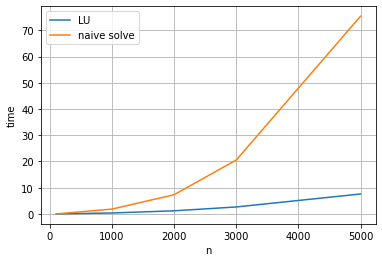

In [13]:
plt.plot(n_values, times_lu,label = 'LU')
plt.plot(n_values, times_solve, label = 'naive solve')
plt.xlabel('n')
plt.ylabel('time')
plt.grid()
plt.legend()

What do you think of these results? Can you explain the difference between both implementations? 


## 2) Changing the stiffness

We could combine two slinkys made of different materials and/or different geometries; that is, we "glue" one to the end of the other. Assume we are connecting two slinkys of same length, and we will discretize each one of them with the same number of springs.

Complete the code snippet below, to repeat the analysis for a mass-spring system with non-uniform stiffness values. We provide the following input variables:

In [14]:
n = 30       # number of springs for each slinky
N = 2*n      # Total number of springs
Ls = 20      # (cm)       Total Length of the slinky
Ks1 = 700    # (N/cm)     Stiffness for the first half of the slinky
Ks2 = 200    # (N/cm)     Stiffness for the second half of the slinky
M1  = 150    # (grams)    Mass for the first half of the slinky
M2  = 70     # (grams)    Mass for the second half of the slinky

k1 = Ks1*n   # each individiual spring stiffness for the first half of the slinky
k2 = Ks2*n   # each individiual spring stiffness for the second half of the slinky

l = Ls/N     # each individual spring length

g = 9.81*10**2 # (m/s^2)  Gravitational constant

#force vector due to gravity
fmix = np.append( get_force(M1/(n+1), g, n), get_force(M2/(n+1), g, n) )

Determine the stiffness matrix for this problem, using the variables above, and the provided function `get_stiffness`. Store the stiffness matrix in the variable `Kmix`.

In [19]:
#grade (do not delete this line)
Kmix = get_stiffness(np.append(k1*np.ones(n), k2*np.ones(n)))

[[ 9493.5483871  -4746.77419355     0.         ...     0.
      0.             0.        ]
 [-4746.77419355  9493.5483871  -4746.77419355 ...     0.
      0.             0.        ]
 [    0.         -4746.77419355  9493.5483871  ...     0.
      0.             0.        ]
 ...
 [    0.             0.             0.         ...  4430.32258065
  -2215.16129032     0.        ]
 [    0.             0.             0.         ... -2215.16129032
   4430.32258065 -2215.16129032]
 [    0.             0.             0.         ...     0.
  -2215.16129032  2215.16129032]]


Once you have the stiffness matrix, you can solve your spring system:

In [20]:
u = la.solve(Kmix,fmix)

And we can use the helper function to plot:

In [21]:
from assemble_functions import draw_slinky

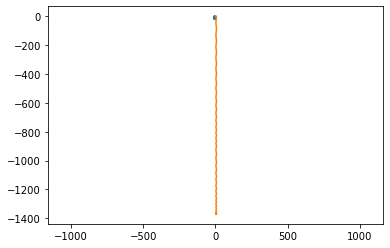

In [22]:
coord = np.array([l*i for i in range(N+1)])
utotal = np.append(0,u)
def_coord = coord + utotal

plt.figure()
plt.axis('equal')
draw_slinky(-5, coord, 2)
draw_slinky(5, def_coord, 2)